# LAB 9 : Transformers

Name : Hrishikesh Pable

Roll Number : 200010037

Preprocessing : 

1. PyTorch tutorial : https://github.com/yunjey/pytorch-tutorial
2. Tranformer : http://peterbloem.nl/blog/transformers
3. Text Preprocessing : https://www.analyticsvidhya.com/blog/2021/06/must-known-techniques-for-text-preprocessing-in-nlp/
4. More abou Self Attention : https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a

# **Problem 1** : Building a Transformer

1. Build a Self Attention Block
2. Use the self attection block to build a transformer block

##Write down the Objectives, Hypothesis and Experimental description for the above problem


## Programming :
  Please write a program to demonstrate the same

**Self Attention Block**

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

import random, math

class SelfAttention(nn.Module):
    def __init__(self, emb, heads=8, mask=False):

        """
        :param emb:
        :param heads:
        :param mask:
        """
        super().__init__()
        
        assert emb % heads == 0

        self.emb = emb
        self.heads = heads
        # self.mask = mask

        self.tokeys = nn.Linear(emb, emb, bias=False)
        self.toqueries = nn.Linear(emb, emb, bias=False)
        self.tovalues = nn.Linear(emb, emb, bias=False)

        self.unifyheads = nn.Linear(emb, emb)

    def forward(self, x):

        b, t, k = x.size()
        h = self.heads
        assert k == self.emb, f'Input embedding dim ({e}) should match layer embedding dim ({self.emb})'
        
        s = k // h

        keys    = self.tokeys(x)   .view(b, t, h, s)
        queries = self.toqueries(x).view(b, t, h, s)
        values  = self.tovalues(x) .view(b, t, h, s)
        
        # - fold heads into the batch dimension
        keys    = keys   .transpose(1, 2).contiguous().view(b * h, t, s)
        queries = queries.transpose(1, 2).contiguous().view(b * h, t, s)
        values  = values .transpose(1, 2).contiguous().view(b * h, t, s)
        
        
        # - get dot product of queries and keys, and scale
        dot = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(s)
        assert dot.size() == (b*h, t, t)
        
        # Normalize
        dot = F.softmax(dot, dim=2)
        
        # Apply the self attention to the values
        out = torch.bmm(dot, values).view(b, h, t, s)
        
        # swap h, t back, unify heads
        out = out.transpose(1, 2).contiguous().view(b, t, h * s)
        
        return self.unifyheads(out)




**Transformer Block**

Create a simple Transformer Block using the self attention block, Transformer block is represented in the below image




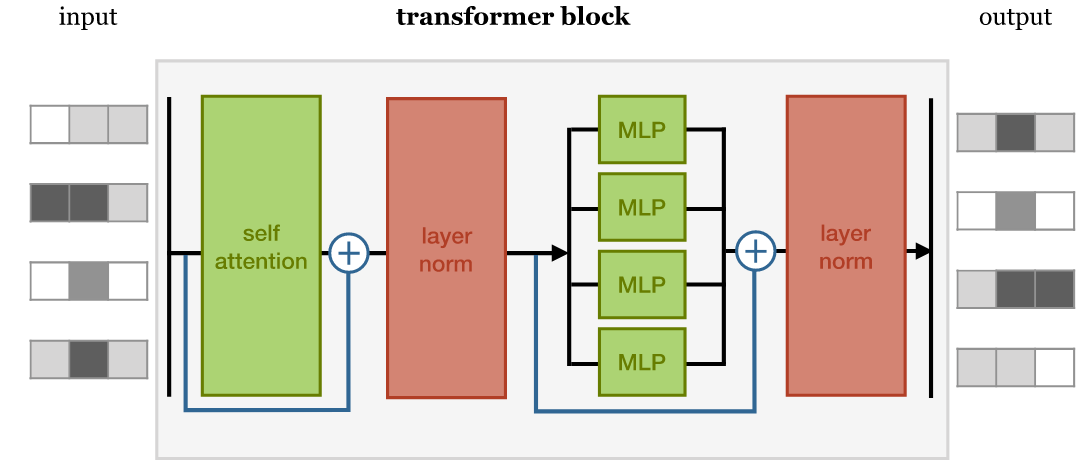

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, emb, heads, mask, seq_length, ff_hidden_mult=4, dropout=0.0):
        super().__init__()

        ## For Layer Norm use nn.LayerNorm()
        ## For Drouput use nn.Dropout()
        ## Apply dropout after every layernorm (can you explain why this is done ??)

        ## Write your code here
        
        self.attention = SelfAttention(emb, heads=heads)
        self.norm1 = nn.LayerNorm(emb)
        self.norm2 = nn.LayerNorm(emb)
        
        ## Feed forward Network is given below :
        self.ff = nn.Sequential(
            nn.Linear(emb, ff_hidden_mult * emb),
            nn.ReLU(),
            nn.Linear(ff_hidden_mult * emb, emb)
        )
        

    def forward(self, x):

        ## Write your code here
        
        attended = self.attention(x)
        x = self.norm1(attended + x)
        fedforward = self.ff(x)
        x = self.norm2(fedforward + x)

        return x

## Inferences and Conclusion : State all the key observations and conclusion

1. Self-attention mechanism is a key component of transformer architecture.

2. Self-attention helps in capturing the dependencies between different words in a sentence by assigning different weights to different words.

3. The transformer block consists of a multi-head self-attention mechanism and a feed-forward neural network. 

# **Problem 2** : Sentiment Analysis using Transformers



1. Consider IMDB sentiment classification dataset or any other sentiment classification datase (Twitter, Amazon food review), consider only Positive and Negative classes.
2. Preprocess the data using text preprocessing texhniques
3. Perform the classification task using the transformer block built earlier (Construct a Classification transformer using the transformer block built above) (Below Image shows the Classification transformer)
4. Report Test accuracy and confusion matrix


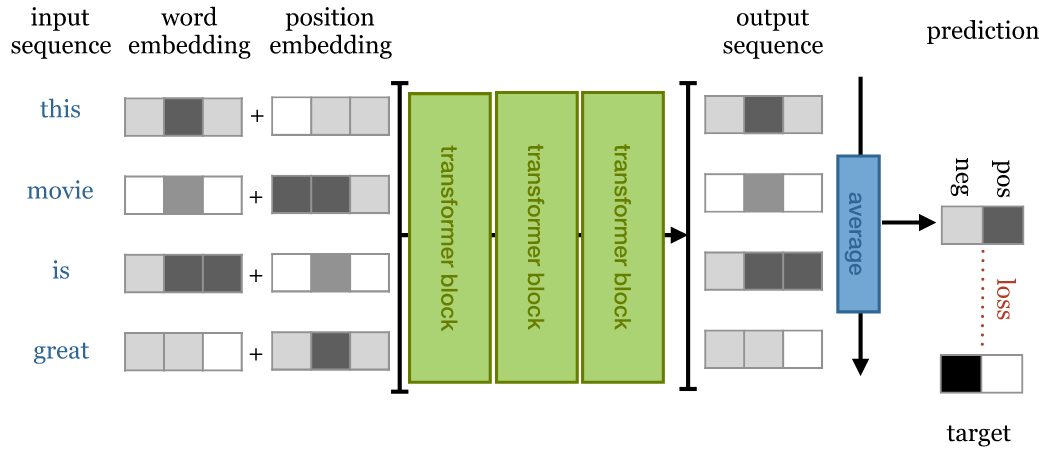

## Write down the Objectives, Hypothesis and Experimental description for the above problem


## Objective

To classify the text into positive and negative sentiment.

## Experimental description



## Programming :
  Please write a program to demonstrate the same

**Use the following configurations as default, you can vary these and observe the performance** :

1. Number of Attention Heads : 8
2. Number of Transformer Blocks : 6
3. Embedding Size : 128
4. Max Sequence Length : 512

**Classification Transformer Block**

In [10]:
import torch
from torch import nn
import torch.nn.functional as F

# Ensure that all tensors are on the same device

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class CTransformer(nn.Module):
    """
    Transformer for classifying sequences
    """

    def __init__(self, emb, heads, depth, seq_length, num_tokens, num_classes, max_pool=True, dropout=0.0, wide=False):
        """
        :param emb: Embedding dimension
        :param heads: nr. of attention heads
        :param depth: Number of transformer blocks
        :param seq_length: Expected maximum sequence length
        :param num_tokens: Number of tokens (usually words) in the vocabulary
        :param num_classes: Number of classes.
        :param max_pool: If true, use global max pooling in the last layer. If false, use global
                         average pooling.
        """
        super().__init__()

        ## Write your code here

        ## For token and positional embeddings use nn.Embedding()
        
        self.num_tokens = num_tokens
    
        self.token_embedding = nn.Embedding(num_tokens, emb)
        self.positional_embedding = nn.Embedding(seq_length, emb)
        
        self.transformer_blocks = []

        for _ in range(depth):
            self.transformer_blocks.append(TransformerBlock(emb, heads, False, seq_length, dropout=dropout))
            
        self.transformer_blocks = nn.Sequential(*self.transformer_blocks)
        
        
        self.toprobs = nn.Linear(emb, num_classes)
            
        
        

    def forward(self, x):

        """
        :param x: A batch by sequence length integer tensor of token indices.
        :return: predicted log-probability vectors for each token based on the preceding tokens.
        """

        ## Write your code here
        
        # generate token embeddings
        tokens = self.token_embedding(x)
        b, t, k = tokens.size()
        
        # generate positional embeddings
        positions = torch.arange(t)
        # Ensure that the positional embeddings are on the same device as the input tokens
        positions = positions.to(device)
        positions = self.positional_embedding(positions)[None, :, :].expand(b, t, k)
        
        x = tokens + positions
        x = self.transformer_blocks(x)
        
        # Average pooling over the sequence
        x = self.toprobs(x.mean(dim=1))
        
        return F.log_softmax(x, dim=1)



In [11]:
# !pip install torchtext

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('imdb_movies_sentiment_dataset/IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
## Split the dataset into train and test; use only 80 samples for training and 20 samples for testing

df_train, df_test = train_test_split(df, train_size=80, test_size=20, random_state=42)

# Reindex the dataframes
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## Preprocess the data 

# Remove punctuation
df_train['review'] = df_train['review'].str.replace('[^\w\s]',' ')
df_test['review'] = df_test['review'].str.replace('[^\w\s]',' ')

# Lowercase the text
df_train['review'] = df_train['review'].str.lower()
df_test['review'] = df_test['review'].str.lower()

# Print the first 5 rows of the dataframe
df_train.head()

## Tokenize the text by splitting the text
df_train['review'] = df_train['review'].str.split()
df_test['review'] = df_test['review'].str.split()

# Print the first 5 rows of the dataframe
df_train.head()
df_train['review']

/tmp/ipykernel_512556/720780259.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train['review'] = df_train['review'].str.replace('[^\w\s]',' ')
/tmp/ipykernel_512556/720780259.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  df_test['review'] = df_test['review'].str.replace('[^\w\s]',' ')


0     [the, production, quality, cast, premise, auth...
1     [i, ve, never, really, been, sure, whether, i,...
2     [send, them, to, the, freezer, this, is, the, ...
3     [this, movie, was, released, originally, as, a...
4     [with, all, this, stuff, going, down, at, the,...
                            ...                        
75    [i, walked, into, the, movie, theater, with, n...
76    [buster, keaton, was, arguably, at, his, most,...
77    [a, beautiful, woman, a, backwoods, inbred, mo...
78    [ok, even, if, you, can, t, stand, liza, this,...
79    [this, was, on, at, 2, or, so, in, the, mornin...
Name: review, Length: 80, dtype: object

In [5]:
# Create a vocabulary of the words
vocab = set()
for i in range(len(df_train['review'])):
    vocab.update(df_train['review'][i])
    
for i in range(len(df_test['review'])):
    vocab.update(df_test['review'][i])

vocab_size = len(vocab)
print("Vocabulary size: ", vocab_size)

# Create a dictionary to word to index mapping
word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {i: word for i, word in enumerate(vocab)}
print("Word to index mapping: ", word_to_idx)


Vocabulary size:  4704
Word to index mapping:  {'church': 0, 'exploits': 1, 'predicted': 2, 'coincides': 3, 'possible': 4, 'sms': 5, 'mindless': 6, 'chessmaster': 7, 'hammerhead': 8, 'assassin': 9, 'reviews': 10, 'craven': 11, 'we': 12, 'called': 13, 'li': 14, 'many': 15, 'sequences': 16, 'letters': 17, 'comrade': 18, 'our': 19, 'interaction': 20, 'skating': 21, '500': 22, 'tans': 23, 'nice': 24, 'mode': 25, 'artistic': 26, 'awkward': 27, 'puzzle': 28, 'those': 29, 'displayed': 30, 'moved': 31, 'allows': 32, 'tear': 33, 'producers': 34, 'falk': 35, 'explain': 36, 'danish': 37, 'finale': 38, 'semi': 39, 'throughout': 40, 'high': 41, 'sail': 42, 'kohler': 43, 'horrors': 44, 'aroused': 45, 'nino': 46, 'came': 47, 'spinal': 48, 'wine': 49, 'grow': 50, 'grant': 51, 'right': 52, 'family': 53, 'whining': 54, 'oscar': 55, 'arrow': 56, 'justice': 57, 'polished': 58, 'villain': 59, 'god': 60, 'realm': 61, 'masks': 62, 'f': 63, 'shares': 64, 'hitting': 65, 'anyone': 66, 'hope': 67, 'belabor': 68,

In [6]:

## Train the CTansformer model

import torch
import torchtext

from torch.utils.data import DataLoader, Dataset

class IMDBDataset(Dataset):
    def __init__(self, df, word_to_idx, max_length=500):
        self.df = df
        self.word_to_idx = word_to_idx
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        review = self.df['review'][idx]
        review = [self.word_to_idx[word] for word in review if word in self.word_to_idx]
        review = review[:self.max_length]
        review = review + [0] * (self.max_length - len(review))
        review = torch.tensor(review)
        label = 1 if self.df['sentiment'][idx] == 'positive' else 0
        return review, label
    
train_dataset = IMDBDataset(df_train, word_to_idx)
test_dataset = IMDBDataset(df_test, word_to_idx)

In [12]:
# Train the CTansformer model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = CTransformer(emb=256, heads=8, depth=8, seq_length=500, num_tokens=vocab_size, num_classes=2, max_pool=True, dropout=0.0, wide=True).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Print the model parameters
# print(model)
print('Number of parameters: ', sum(p.numel() for p in model.parameters() if p.requires_grad))

for epoch in range(5):
    model.train()
    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Epoch {epoch}, Iteration {i}, Loss: {loss.item()}')

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f'Epoch {epoch}, Test Accuracy: {100 * correct / total}')




In [ ]:
# Train the CTransformer model

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import tqdm

NUM_CLS = 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'



def train_model(model, train_iter, test_iter, max_length, num_epochs, lr, gradient_clipping, tb_dir):
    """
    Train the transformer model.
    """

    opt = torch.optim.Adam(lr=lr, params=model.parameters())
    sch = torch.optim.lr_scheduler.LambdaLR(opt, lambda i: 1.0)  

    seen = 0
    for e in range(num_epochs):
        print(f'\n epoch {e}')
        model.train(True)

        for batch in tqdm.tqdm(train_iter):
            opt.zero_grad()

            input = batch[0]
            label = batch[1] - 1

            if input.size(1) > max_length:
                input = input[:, :max_length]
                
            out = model(input)
            loss = F.nll_loss(out, label)

            loss.backward()

            if gradient_clipping > 0.0:
                nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)

            opt.step()
            sch.step()

            seen += input.size(0)
            tbw.add_scalar('classification/train-loss', float(loss.item()), seen)

        with torch.no_grad():
            model.train(False)
            tot, cor= 0.0, 0.0

            for batch in test_iter:
                input = batch.text[0]
                label = batch.label - 1

                if input.size(1) > max_length:
                    input = input[:, :max_length]
                out = model(input).argmax(dim=1)

                tot += float(input.size(0))
                cor += float((label == out).sum().item())

            acc = cor / tot
            print(f'-- test accuracy {acc:.3}')
            tbw.add_scalar('classification/test-loss', float(loss.item()), e)

# Define the arguments for training
args = {
    'num_epochs': 5,
    'batch_size': 16,
    'lr': 0.001,
    'tb_dir': './runs',
    'final': False,
    'max_pool': True,
    'embedding_size': 256,
    'vocab_size': 50000,
    'max_length': 500,
    'num_heads': 8,
    'depth': 8,
    'gradient_clipping': 1.0
}

# Create the model
model = CTransformer(emb=args['embedding_size'], heads=args['num_heads'], depth=args['depth'], seq_length=args['max_length'], num_tokens=args['vocab_size'], num_classes=2, max_pool=args['max_pool'])

# Move the model to GPU if available
if torch.cuda.is_available():
    model.cuda()

# Train the model
train_model(model, train_loader, test_loader, args['max_length'], args['num_epochs'], args['lr'], args['gradient_clipping'], args['tb_dir'])


In [ ]:
# Finally test the model accuracy on the test set

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    print(f'Test Accuracy: {100 * correct / total}')
    
    
    

## Inferences and Conclusion : State all the key observations and conclusion

1. Transformers can be used to perform sentiment classification for text data.

2. The model can be trained to classify the text into positive and negative sentiment.

3. Multi-head attention is useful for capturing the relationship between words in the text.